# Initialization, configure API host and key, and create new API instance

In [1]:
import os
import csv
import json
import datetime
import time
import nucleus_api
from nucleus_api.rest import ApiException
from nucleus_api.api.nucleus_api import topic_charts_historical,summarize_file_url
from pprint import pprint
import numpy as np

# Determine if in Jupyter notebook or not
try:
    ip = get_ipython()
    running_notebook = True
except NameError:
    running_notebook = False

if running_notebook:
    print('Running example in Jupyter Notebook')
else:
    print('Running example in script mode')
    
configuration = nucleus_api.Configuration()
configuration.host = 'UPDATE-WITH-API-HOST'
configuration.api_key['x-api-key'] = 'UPDATE-WITH-API-KEY'

# Create API instance
api_instance = nucleus_api.NucleusApi(nucleus_api.ApiClient(configuration))

Running example in Jupyter Notebook


# Dataset APIs

## Append file from local drive to dataset

In [2]:
print('--------- Append file from local drive to dataset -----------')
file = 'quarles20181109a.pdf'         # file | 
dataset = 'dataset_test'              # str | Destination dataset where the file will be inserted.
metadata = {"time": "1/2/2018", 
            "author": "Test Author"}  # Optional json containing additional document metadata

try:
    api_response = api_instance.post_upload_file(file, dataset, metadata=metadata)
    #print('api_response=', api_response)   # raw API response    
except ApiException as e:
    print("Exception when calling DatasetsApi->post_upload_file: %s\n" % e)
    exit


print(api_response.result, 'has been added to dataset', dataset)
print('-------------------------------------------------------------')

--------- Append file from local drive to dataset -----------
quarles20181109a.pdf has been added to dataset dataset_test
-------------------------------------------------------------


# Append all files from local folder to dataset

In [3]:
print('--------- Append all files from local folder to dataset -----------')
folder = 'fomc-minutes'         

dataset = 'dataset_test'              # str | Destination dataset where the file will be inserted.
metadata = {"time": "1/2/2018", 
            "author": "Test Author"}  # Optional json containing additional document metadata

for root, dirs, files in os.walk(folder):
    for file in files:
        file = os.path.join(root, file)
        
        try:
            api_response = api_instance.post_upload_file(file, dataset, metadata=metadata)
            #print('api_response=', api_response)   # raw API response    
        except ApiException as e:
            print("Exception when calling DatasetsApi->post_upload_file: %s\n" % e)
            exit


        print(api_response.result, 'has been added to dataset', dataset)

print('-------------------------------------------------------------')

--------- Append all files from local folder to dataset -----------
fomcminutes20181219.pdf has been added to dataset dataset_test
fomcminutes20181108.pdf has been added to dataset dataset_test
-------------------------------------------------------------


## Append file from URL to dataset

In [30]:
print('------------ Append file from URL to dataset ---------------')

dataset = 'dataset_test'
file_url = 'https://s3-us-west-2.amazonaws.com/sumup-public/nucleus-sdk/quarles20181109a.docx'
# Optional filename saved on the server for the URL. If not specified, Nucleus will make
# an intelligent guess from the file URL
filename = 'quarles20181109a-newname.pdf'  
payload = nucleus_api.UploadURLModel(
                dataset=dataset,
                file_url=file_url,
                filename=filename  
            ) # UploadURLModel | 

try:
    api_response = api_instance.post_upload_url(payload)
    #print('api_response=', api_response)   # raw API response
except ApiException as e:
    print("Exception when calling DatasetsApi->post_upload_url: %s\n" % e)
    
print(api_response.result, 'has been added to dataset', dataset)
print('-------------------------------------------------------------')

------------ Append file from URL to dataset ---------------
https://s3-us-west-2.amazonaws.com/sumup-public/nucleus-sdk/quarles20181109a.docx has been added to dataset dataset_test
-------------------------------------------------------------


## Append json from csv to dataset

In [5]:
# This dataset will be used to test all topics and documents APIs
print('----------- Append json from CSV to dataset -----------------')
csv_file = 'trump-tweets-100.csv'
dataset = 'dataset_test'  

with open(csv_file, encoding='utf-8-sig') as csvfile:
    reader = csv.DictReader(csvfile)
    doc_count = 0
    for row in reader:
        payload = nucleus_api.Appendjsonparams(dataset=dataset, 
                                               #language='english', #optional. language can be auto detected
                                               document={'time'   : row['time'],
                                                         'title'  : row['title'],
                                                         'content': row['content'],
                                                         'author' : row['author']}
                                              )

        try:
            api_response = api_instance.post_append_json_to_dataset(payload)
            #print('api_response', api_response)
        except ApiException as e:
            print("Exception when calling DatasetsApi->post_append_json_to_dataset: %s\n" % e)
            
        doc_count += 1
        
print(doc_count, 'documents added to dataset', dataset)
print('-------------------------------------------------------------')

----------- Append json from CSV to dataset -----------------
100 documents added to dataset dataset_test
-------------------------------------------------------------


## List available datasets

In [6]:
print('---------------- List available datasets ---------------------')
try:
    api_response = api_instance.get_list_datasets()
except ApiException as e:
    print("Exception when calling DatasetsApi->get_list_datasets: %s\n" % e)

list_datasets = api_response.result

print(len(list_datasets), 'datasets in the database:')
for ds in list_datasets:
    print('    ', ds)

    
print('-------------------------------------------------------------')

---------------- List available datasets ---------------------
6 datasets in the database:
     dataset_test
     jim_wu_sumup_ai_fed_1547146082933
     jim_wu_sumup_ai_txt_encode_1546896541648
     jim_wu_sumup_aimit_tech_review1545314792621
     trump_tweets
     trump_tweets_full
-------------------------------------------------------------


## Get dataset information

In [7]:
print('--------------- Get dataset information -------------------')
dataset = 'dataset_test' # str | Dataset name.
query = '' # str | Fulltext query, using mysql MATCH boolean query format. (optional)
metadata_selection = '' # str | json object of {\"metadata_field\":[\"selected_values\"]} (optional)
time_period = '' # str | Time period selection (optional)

try:
    api_response = api_instance.get_dataset_info(
        dataset, 
        query=query, 
        metadata_selection=metadata_selection, 
        time_period=time_period)
    #print('api_response=', api_response) # raw API response
except ApiException as e:
    print("Exception when calling DatasetsApi->get_dataset_info: %s\n" % e)

print('Information about dataset', dataset)
print('    Language:', api_response.result.detected_language)
print('    Number of documents:', api_response.result.num_documents)
print('    Time range:', datetime.datetime.fromtimestamp(float(api_response.result.time_range[0])),
             'to', datetime.datetime.fromtimestamp(float(api_response.result.time_range[1])))


print('-------------------------------------------------------------')

--------------- Get dataset information -------------------
Information about dataset dataset_test
    Language: en
    Number of documents: 105
    Time range: 2018-01-02 00:00:00 to 2019-01-10 22:50:18
-------------------------------------------------------------


## Delete document

In [8]:
print('--------------------- Delete document -----------------------')
dataset = 'dataset_test'
docid = '1'
payload = nucleus_api.Deletedocumentmodel(dataset=dataset,
                                             docid=docid) # Deletedocumentmodel | 

try:
    api_response = api_instance.post_delete_document(payload)
except ApiException as e:
    print("Exception when calling DatasetsApi->post_delete_document: %s\n" % e)


print('Document', docid, 'from dataset', dataset, 'has been deleted.')
# print(api_response)     # raw API response
print('-------------------------------------------------------------')

--------------------- Delete document -----------------------
Document 1 from dataset dataset_test has been deleted.
-------------------------------------------------------------


## Delete dataset

In [9]:
print('--------------------- Delete dataset ------------------------')

dataset = 'dataset_test'  
payload = nucleus_api.Deletedatasetmodel(dataset=dataset) # Deletedatasetmodel | 

try:
    api_response = api_instance.post_delete_dataset(payload)
    pprint(api_response)
except ApiException as e:
    print("Exception when calling DatasetsApi->post_delete_dataset: %s\n" % e)
    
# List datasets again to check if the specified dataset has been deleted
try:
    api_response = api_instance.get_list_datasets()
    #print('api_response=', api_response)
except ApiException as e:
    print("Exception when calling DatasetsApi->get_list_datasets: %s\n" % e)
    
print('-------------------------------------------------------------')

--------------------- Delete dataset ------------------------
{'job_id': None, 'result': 'Dataset deleted'}
-------------------------------------------------------------


# Topic APIs

## Get list of topics from dataset

In [10]:
print('------------- Get list of topics from dataset --------------')
dataset = 'trump_tweets'
#query = '("Trump" OR "president")' # str | Fulltext query, using mysql MATCH boolean query format. Example, (\"word1\" OR \"word2\") AND (\"word3\" OR \"word4\") (optional)
query = ''
custom_stop_words = ["real","hillary"] # str | List of stop words. (optional)
num_topics = 8 # int | Number of topics to be extracted from the dataset. (optional) (default to 8)
metadata_selection ="" # str | json object of {\"metadata_field\":[\"selected_values\"]} (optional)
time_period =""# str | Time period selection (optional)

try:
    api_response = api_instance.get_topic_api(
        dataset,                                
        query=query,                   
        custom_stop_words=custom_stop_words,     
        num_topics=num_topics,
        metadata_selection=metadata_selection,
        time_period=time_period)
except ApiException as e:
    print("Exception when calling TopicsApi->get_topic_api: %s\n" % e)
    
#print(api_response)
i = 1
for res in api_response.result:
    print('Topic', i, 'keywords:')
    print('    Keywords:', res.topic)
    keywords_weight_str = ";".join(str(x) for x in res.keywords_weight)
    print('    Keyword weights:', keywords_weight_str)
    print('    Strength:', res.strength)
    doc_topic_exposure_sel = []  # list of non-zero doc_topic_exposure
    doc_id_sel = []        # list of doc ids matching doc_topic_exposure_sel
    for j in range(len(res.doc_topic_exposure)):
        doc_topic_exp = float(res.doc_topic_exposure[j])
        if doc_topic_exp != 0:
            doc_topic_exposure_sel.append(doc_topic_exp)
            doc_id_sel.append(res.doc_id[j])
    
    doc_id_sel_str = ' '.join(str(x) for x in doc_id_sel)
    doc_topic_exposure_sel_str = ' '.join(str(x) for x in doc_topic_exposure_sel)
    print('    Document IDs:', doc_id_sel_str)
    print('    Document exposures:', doc_topic_exposure_sel_str)

    print('---------------')
    i = i + 1
    
print('-------------------------------------------------------------')

------------- Get list of topics from dataset --------------
Topic 1 keywords:
    Keywords: illegal aliens;united permission;permission illegal;enter united;aliens treated;aliens illegal;treated entered;left haywire
    Keyword weights: 0.1245799948307056;0.06397001809253038;0.06397001809253038;0.1245799948307056;0.1245799948307056;0.1245799948307056;0.2491599896614112;0.1245799948307056
    Strength: 0.1778178987910782
    Document IDs: 57 63 457 463
    Document exposures: 0.24361226030827163 0.23113677211743835 0.26990959957549243 0.2553413679987976
---------------
Topic 2 keywords:
    Keywords: bruce ohr;ohr justice;justice department;wife nelly;fusion gps;christopher steele;disgraced christopher;department believe
    Keyword weights: 0.20881332098544583;0.10614053369547578;0.12069796535946312;0.14368419449796907;0.12069796535946312;0.14368419449796907;0.07814091280210698;0.07814091280210698
    Strength: 0.18530292197975734
    Document IDs: 11 12 13 31 33 70 413 433 470
    Do

## Get topic summary

In [11]:
print('------------------- Get topic summary -----------------------')
dataset = 'trump_tweets' # str | Dataset name.
#query = '("Trump" OR "president")' # str | Fulltext query, using mysql MATCH boolean query format. Example, (\"word1\" OR \"word2\") AND (\"word3\" OR \"word4\") (optional)
query = ''
custom_stop_words = ["real","hillary"] # str | List of stop words. (optional)
num_topics = 8 # int | Number of topics to be extracted from the dataset. (optional) (default to 8)
num_keywords = 8 # int | Number of keywords per topic that is extracted from the dataset. (optional) (default to 8)
metadata_selection ="" # str | json object of {\"metadata_field\":[\"selected_values\"]} (optional)
summary_length = 6 # int | The maximum number of bullet points a user wants to see in each topic summary. (optional) (default to 6)
context_amount = 0 # int | The number of sentences surrounding key summary sentences in the documents that they come from. (optional) (default to 0)
num_docs = 20 # int | The maximum number of key documents to use for summarization. (optional) (default to 20)
excluded_docs = '' # str | List of document IDs that should be excluded from the analysis. Example, \"docid1, docid2, ..., docidN\"  (optional)

try:
    api_response = api_instance.get_topic_summary_api(
        dataset, 
        query=query, 
        custom_stop_words=custom_stop_words, 
        num_topics=num_topics, 
        num_keywords=num_keywords,
        metadata_selection=metadata_selection,
        summary_length=summary_length, 
        context_amount=context_amount, 
        num_docs=num_docs)
except ApiException as e:
    print("Exception when calling TopicsApi->get_topic_summary_api: %s\n" % e)

i = 1
for res in api_response.result:
    print('Topic', i, 'summary:')
    print('    Keywords:', res.topic)
    for j in range(len(res.summary)):
        print('    Document ID:', res.summary[j].sourceid)
        print('        Title:', res.summary[j].title)
        print('        Sentences:', res.summary[j].sentences)
        print('        Author:', res.summary[j].attribute.author)
        print('        Source:', res.summary[j].attribute.source)
        print('        Time:', datetime.datetime.fromtimestamp(float(res.summary[j].attribute.time)))

        #print(type(res.summary[j].attribute))
        
    print('---------------')
    i = i + 1
    
    
#pprint(api_response)  # raw API response
print('-------------------------------------------------------------')



------------------- Get topic summary -----------------------
Topic 1 summary:
    Keywords: illegal aliens;united permission;permission illegal;enter united;aliens treated;aliens illegal;treated entered;left haywire
    Document ID: 57
        Title: D_Trump2018_8_15_13_18
        Sentences: ['“People who enter the United States without our permission are illegal aliens and illegal aliens should not be treated the same as people who entered the U.S. legally.” Chuck Schumer in 2009 before he went left and haywire!']
        Author: D_Trump57
        Source: None
        Time: 2018-08-15 13:18:00
    Document ID: 63
        Title: D_Trump2018_8_15_12_44
        Sentences: ['“People who enter the United States without our permission are illegal aliens and illegal aliens should not be treated the same as people who enters the U.S. legally.”  Chuck Schumer in 2009 before he went left and haywire!']
        Author: D_Trump63
        Source: None
        Time: 2018-08-15 12:44:00
    Documen

## Get topic sentiment

In [12]:
print('---------------- Get topic sentiment ------------------------')
dataset = 'trump_tweets' # str | Dataset name.
#query = '("Trump" OR "president")' # str | Fulltext query, using mysql MATCH boolean query format. Example, (\"word1\" OR \"word2\") AND (\"word3\" OR \"word4\") (optional)
query = ''
custom_stop_words = ["real","hillary"] # str | List of stop words. (optional)
num_topics = 8 # int | Number of topics to be extracted from the dataset. (optional) (default to 8)
num_keywords = 8 # int | Number of keywords per topic that is extracted from the dataset. (optional) (default to 8)
excluded_docs = '' # str | List of document IDs that should be excluded from the analysis. Example, \"docid1, docid2, ..., docidN\"  (optional)
custom_dict_file = 'custom-sentiment-dict.json' # file | Custom sentiment dictionary JSON file. (optional)

try:
    api_response = api_instance.post_topic_sentiment_api(
        dataset, 
        query=query, 
        custom_stop_words=custom_stop_words, 
        num_topics=num_topics, 
        num_keywords=num_keywords,
        custom_dict_file=custom_dict_file)
    
except ApiException as e:
    print("Exception when calling TopicsApi->post_topic_sentiment_api: %s\n" % e)

i = 1
for res in api_response.result:
    print('Topic', i, 'sentiment:')
    print('    Keywords:', res.topic)
    print('    Sentiment:', res.sentiment)
    print('    Strength:', res.strength)
    
    doc_id_str = ' '.join(str(x) for x in res.doc_id)
    doc_sentiment_str = ' '.join(str(x) for x in res.doc_sentiment)
    doc_score_str = ' '.join(str(x) for x in res.doc_score)
    print('    Document IDs:', doc_id_str)
    print('    Document Sentiments:', doc_sentiment_str)
    print('    Document Scores:', doc_score_str)
    
    print('---------------')
    i = i + 1
    
#pprint(api_response)
print('-------------------------------------------------------------')

---------------- Get topic sentiment ------------------------
Topic 1 sentiment:
    Keywords: illegal aliens;united permission;permission illegal;enter united;aliens treated;aliens illegal;treated entered;left haywire
    Sentiment: 0.0
    Strength: 0.1778178987910782
    Document IDs: 57 63 457 463
    Document Sentiments: 0.0 0.0 0.0 0.0
    Document Scores: [0.24361226030827163, 0.23113677211743835, 0.26990959957549243, 0.25534136799879753]
---------------
Topic 2 sentiment:
    Keywords: bruce ohr;ohr justice;justice department;wife nelly;fusion gps;christopher steele;disgraced christopher;department believe
    Sentiment: -0.038696359886190995
    Strength: 0.18530292197975734
    Document IDs: 11 12 13 31 33 70 413 433 470
    Document Sentiments: 0.0 0.0 0.0 0.0 0.0 -0.10526315789473684 0.0 0.0 -0.1111111111111111
    Document Scores: [0.06553228505481294, 0.06553228505481294, 0.05413830650983829, 0.07567016483401508, 0.14174915802079993, 0.17635831304213426, 0.060528466771358

## Get topic consensus

In [13]:
print('---------------- Get topic consensus ------------------------')
dataset = 'trump_tweets' # str | Dataset name.
query = '' # str | Fulltext query, using mysql MATCH boolean query format. Example, (\"word1\" OR \"word2\") AND (\"word3\" OR \"word4\") (optional)
custom_stop_words = ["real","hillary"] # str | List of stop words. (optional)
num_topics = 8 # int | Number of topics to be extracted from the dataset. (optional) (default to 8)
num_keywords = 8 # int | Number of keywords per topic that is extracted from the dataset. (optional) (default to 8)
excluded_docs = [''] # str | List of document IDs that should be excluded from the analysis. Example, \"docid1, docid2, ..., docidN\"  (optional)
custom_dict_file = 'custom-sentiment-dict.json'  # file | Custom sentiment dictionary JSON file. (optional)
try:
    api_response = api_instance.post_topic_consensus_api(
        dataset, 
        query=query, 
        custom_stop_words=custom_stop_words, 
        num_topics=num_topics, 
        num_keywords=num_keywords,
        custom_dict_file=custom_dict_file)
except ApiException as e:
    print("Exception when calling TopicsApi->post_topic_consensus_api: %s\n" % e)
    
i = 1
for res in api_response.result:
    print('Topic', i, 'consensus:')
    print('    Keywords:', res.topic)
    print('    Consensus:', res.consensus)
    print('    Strength:', res.strength)
    
    print('---------------')
    i = i + 1
    
#pprint(api_response) # raw API response
print('-------------------------------------------------------------')

---------------- Get topic consensus ------------------------
Topic 1 consensus:
    Keywords: illegal aliens;united permission;permission illegal;enter united;aliens treated;aliens illegal;treated entered;left haywire
    Consensus: 1.0
    Strength: 0.1778178987910782
---------------
Topic 2 consensus:
    Keywords: bruce ohr;ohr justice;justice department;wife nelly;fusion gps;christopher steele;disgraced christopher;department believe
    Consensus: 0.6424507445483792
    Strength: 0.18530292197975734
---------------
Topic 3 consensus:
    Keywords: andrew cuomo;total meltdown;taxed andrew;highest taxed;governor highest;cuomo total;believe governor;america great
    Consensus: 0.7186340914982743
    Strength: 0.14157765543316195
---------------
Topic 4 consensus:
    Keywords: peter strzok;fired fbi;agent peter;fbi agent;disgraced fired;nelly fusion;fbi received;documents bruce
    Consensus: 0.756822153519598
    Strength: 0.12042158322174128
---------------
Topic 5 consensus:
   

## Get topic historical analysis

------------ Get topic historical analysis ----------------
Plotting historical metrics data...


/Users/jimw/venv/py3-api/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


-------------------------------------------------------------


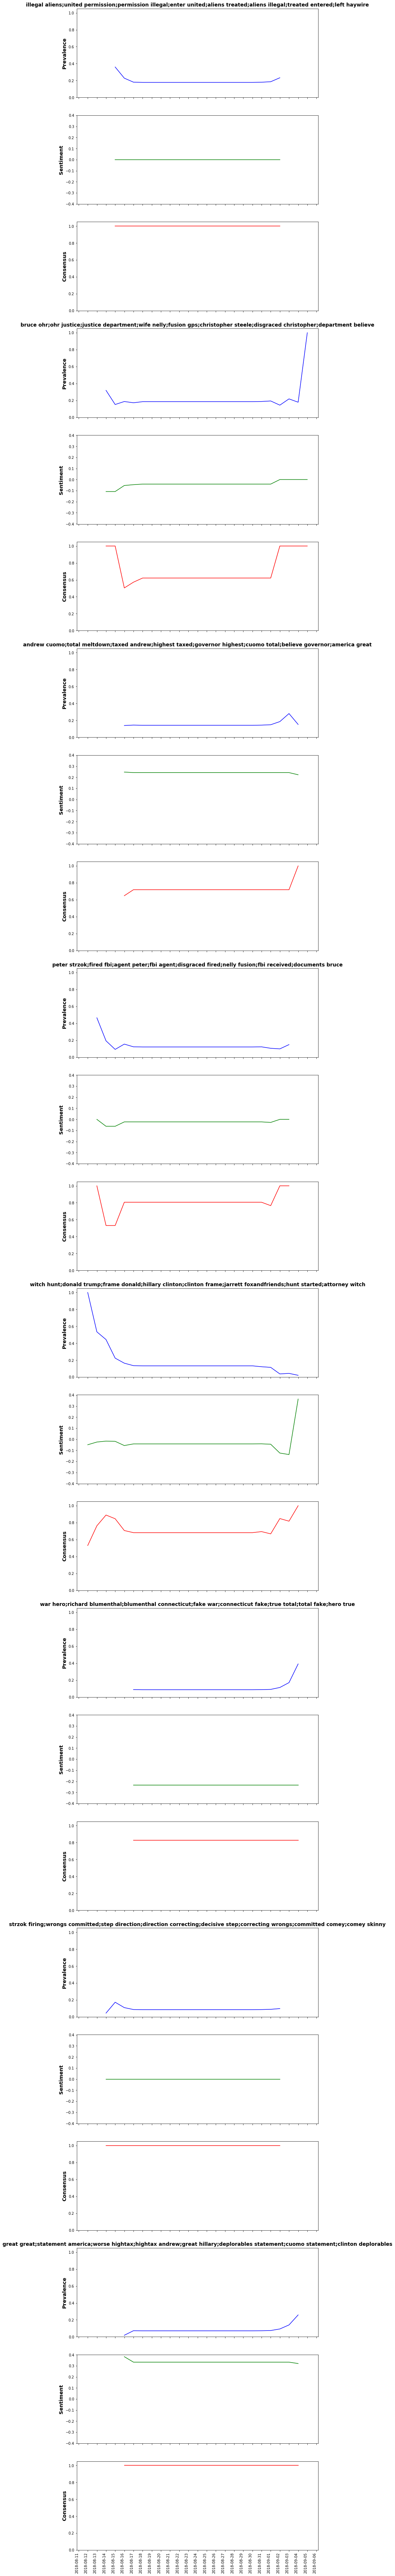

In [14]:
print('------------ Get topic historical analysis ----------------')

dataset = 'trump_tweets'   # str | Dataset name.
time_period = '6M'  # str | Time period selection (default to 1M)
update_period = 'd' # str | Frequency at which the historical anlaysis is performed (default to d)
query = '' # str | Fulltext query, using mysql MATCH boolean query format. Example, (\"word1\" OR \"word2\") AND (\"word3\" OR \"word4\") (optional)
custom_stop_words = ["real","hillary"] # str | List of stop words (optional)
num_topics = 8 # int | Number of topics to be extracted from the dataset. (optional) (default to 8)
num_keywords = 8 # int | Number of keywords per topic that is extracted from the dataset. (optional) (default to 8)
metadata_selection = '' # str | json object of {\"metadata_field\":[\"selected_values\"]} (optional)
inc_step = 1 # int | Number of increments of the udpate period in between two historical computations. (optional) (default to 1)
excluded_docs = [''] # str | List of document IDs that should be excluded from the analysis. Example, \"docid1, docid2, ..., docidN\"  (optional)
custom_dict_file = 'custom-sentiment-dict.json' # file | Custom sentiment dictionary JSON file. (optional)

try:
    api_response = api_instance.post_topic_historical_analysis_api(
        dataset, 
        time_period, 
        update_period, 
        query=query, 
        custom_stop_words=custom_stop_words, 
        num_topics=num_topics, 
        num_keywords=num_keywords, 
        metadata_selection=metadata_selection, 
        inc_step=inc_step, 
        excluded_docs=excluded_docs,
        custom_dict_file=custom_dict_file)
    
except ApiException as e:
    print("Exception when calling TopicsApi->post_topic_historical_analysis_api: %s\n" % e)

#print('api_response=', api_response)
results = api_response.result

# chart the historical metrics when running in Jupyter Notebook
if running_notebook:
    print('Plotting historical metrics data...')
    historical_metrics = []
    for res in results:
        # conctruct a list of historical metrics dictionaries for charting
        historical_metrics.append({
            'topic'    : res.topic,
            'time_stamps' : np.array(res.time_stamps),
            'strength' : np.array(res.strength, dtype=np.float32),
            'consensus': np.array(res.consensus, dtype=np.float32), 
            'sentiment': np.array(res.sentiment, dtype=np.float32)})

    selected_topics = range(len(historical_metrics)) 
    topic_charts_historical(historical_metrics, selected_topics, True)
else:
    print('Printing historical metrics data...')
    print('NOTE: historical metrics data can be plotted when running the example in Jupyter Notebook')
    i = 1
    for res in results:
        print('Topic', i, res.topic)
        print('    Timestamps:', res.time_stamps)
        print('    Strength:', res.strength)
        print('    Consensus:', res.consensus)
        print('    Sentiment:', res.sentiment)
        print('----------------')
        i = i + 1
#pprint(api_response)
print('-------------------------------------------------------------')

## Get author connectivity

In [15]:
print('----------------- Get author connectivity -------------------')
dataset = dataset # str | Dataset name.
target_author = 'D_Trump16' # str | Name of the author to be analyzed.
query = '' # str | Fulltext query, using mysql MATCH boolean query format. Subject covered by the author, on which to focus the analysis of connectivity. Example, (\"word1\" OR \"word2\") AND (\"word3\" OR \"word4\") (optional)
custom_stop_words = ["real","hillary"] # str | List of words possibly used by the target author that are considered not information-bearing. (optional)
time_period = '12M' # str | Time period selection. Required. Valid values: "1M","3M","6M","12M","3Y","5Y"
metadata_selection = '' # str | json object of {\"metadata_field\":[\"selected_values\"]} (optional)
excluded_docs = [''] # str | List of document IDs that should be excluded from the analysis. Example, \"docid1, docid2, ..., docidN\"  (optional)

try:
    api_response = api_instance.get_author_connectivity_api(
        dataset, 
        target_author, 
        query=query, 
        custom_stop_words=custom_stop_words, 
        time_period=time_period, 
        metadata_selection=metadata_selection, 
        excluded_docs=excluded_docs)
    
except ApiException as e:
    print("Exception when calling TopicsApi->get_author_connectivity_api: %s\n" % e)

res = api_response.result
print('Mainstream connections:')
for mc in res.mainstream_connection:
    print('    Topic:', mc.topic)
    print('    Authors:', " ".join(str(x) for x in mc.authors))
    
print('Niche connections:')
for nc in res.niche_connection:
    print('    Topic:', nc.topic)
    print('    Authors:', " ".join(str(x) for x in nc.authors))  
    
#pprint(api_response)   # raw API response
print('-------------------------------------------------------------')

----------------- Get author connectivity -------------------
Mainstream connections:
    Topic: hillary clinton;hightax andrew;deplorables statement
    Authors: D_Trump69
Niche connections:
    Topic: worse hightax;statement america;andrew cuomo
    Authors: D_Trump18
-------------------------------------------------------------


# Get topic delta

In [16]:
print('------------------- Get topic deltas -----------------------')
dataset = 'trump_tweets' 
#dataset = dataset # str | Dataset name.
#query = '("Trump" OR "president")' # str | Fulltext query, using mysql MATCH boolean query format. Example, (\"word1\" OR \"word2\") AND (\"word3\" OR \"word4\") (optional)
query = ''
custom_stop_words = [""] # str | List of stop words. (optional)
num_topics = 8 # int | Number of topics to be extracted from the dataset. (optional) (default to 8)
num_keywords = 8 # int | Number of keywords per topic that is extracted from the dataset. (optional) (default to 8)
metadata_selection ="" # str | json object of {\"metadata_field\":[\"selected_values\"]} (optional)
time_start_t0 = '2018-08-12 00:00:00'
time_end_t0 = '2018-08-15 13:00:00'
time_start_t1 = '2018-08-16 00:00:00'
time_end_t1 = '2018-08-19 00:00:00'
excluded_docs = '' # str | List of document IDs that should be excluded from the analysis. Example, \"docid1, docid2, ..., docidN\"  (optional)

try:
    api_response = api_instance.get_topic_delta_api(
        dataset, 
        query=query, 
        custom_stop_words=custom_stop_words, 
        num_topics=num_topics, 
        num_keywords=num_keywords,
        time_start_t0 = time_start_t0,
        time_end_t0 = time_end_t0,
        time_start_t1 = time_start_t1,
        time_end_t1 = time_end_t1,
        metadata_selection=metadata_selection)
except ApiException as e:
    print("Exception when calling TopicsApi->get_topic_delta_api: %s\n" % e)

i = 1
for res in api_response.result:
    print('Topic', i, 'changes in exposure:')
    print('    Keywords:', res.topic)
    print('    Document ID:', res.doc_id_t0, res.doc_id_t1)
    print('    Per Source Change in Exposure:', res.doc_topic_exposure_delta)
    print('---------------')
    i = i + 1
    
    
#pprint(api_response)  # raw API response
print('-------------------------------------------------------------')




------------------- Get topic deltas -----------------------
Topic 1 changes in exposure:
    Keywords: donald trump;witch hunt;hillary clinton;frame donald;clinton frame;real attorney;hunt started;gregg jarrett
    Document ID: ['62', '63', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '80', '81', '82', '83', '84', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '463', '469', '470', '498'] ['2', '3', '4', '6', '7', '8', '9', '10', '11', '12', '13', '15', '16', '17', '18', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '413', '430', '432', '433', '444', '447']
    Per Source Change in Exposure: ['-0.0', '-0.0', '-0.0', '-0.0', '-0.05451940392818219', '-0.0', '-0.3741423003974582', '-0.0', '-0.0', '-0.0', '-0.0', '-0.0', '-0.0', '-0.0', '-0.0', '-0.0', '-0.0', '-0.0', '-0.0', '-0.0', '-0.0', '-0.0', '-0.0', '-0.0', '-0

# Document APIs

## Get document information without content

In [17]:
dataset = 'trump_tweets' # str | Dataset name.
doc_titles = ['D_Trump2018_8_18_1_47']   # str | The title of the document to retrieve. Example: \" \"title 1\" \"  (optional)
doc_ids = ['11', '12', '20']      # int | The docid of the document to retrieve. Example: \"docid1\"  (optional)

try:
    api_response = api_instance.get_doc_info(dataset, doc_titles=doc_titles, doc_ids=doc_ids)
    
except ApiException as e:
    print("Exception when calling DocumentsApi->get_doc_info: %s\n" % e)
    
for res in api_response.result:
    print('Document ID:', res.sourceid)
    print('    Title:', res.title)
    print('    Author:', res.attribute.author)
    print('    Source:', res.attribute.source)
    print('    Time:', datetime.datetime.fromtimestamp(float(res.attribute.time)))

    print('---------------')
    
    
#pprint(api_response)  # raw response from API server
print('-------------------------------------------------------------')

Document ID: 10
    Title: D_Trump2018_8_18_1_47
    Author: D_Trump10
    Source: None
    Time: 2018-08-18 01:47:00
---------------
Document ID: 11
    Title: D_Trump2018_8_18_1_46
    Author: D_Trump11
    Source: None
    Time: 2018-08-18 01:46:00
---------------
Document ID: 12
    Title: D_Trump2018_8_18_1_37
    Author: D_Trump12
    Source: None
    Time: 2018-08-18 01:37:00
---------------
Document ID: 20
    Title: D_Trump2018_8_17_12_38
    Author: D_Trump20
    Source: None
    Time: 2018-08-17 12:38:00
---------------
-------------------------------------------------------------


## Display document details

In [18]:
print('-------------------------------------------------------------')

dataset = 'trump_tweets' # str | Dataset name.
#doc_titles = ['D_Trump2018_8_18_1_47']   # str | The title of the document to retrieve. Example: \" \"title 1\" \"  (optional)
doc_ids = ['1']      # int | The docid of the document to retrieve. Example: \"docid1\"  (optional)

try:
    api_response = api_instance.get_doc_display(dataset, 
                                                    #doc_titles=doc_titles, 
                                                    doc_ids=doc_ids)
    
except ApiException as e:
    print("Exception when calling DocumentsApi->get_doc_display_api: %s\n" % e)

for res in api_response.result:
    print('Document ID:', res.sourceid)
    print('    Title:', res.title)
    print('    Author:', res.attribute.author)
    print('    Source:', res.attribute.source)
    print('    Time:', datetime.datetime.fromtimestamp(float(res.attribute.time)))
    print('    Content', res.content)

    print('---------------')


#pprint(api_response) # raw response from API server
print('-------------------------------------------------------------')

-------------------------------------------------------------
Document ID: 1
    Title: D_Trump2018_8_18_19_39
    Author: D_Trump1
    Source: None
    Time: 2018-08-18 19:39:00
    Content 
---------------
-------------------------------------------------------------


## Get document recommendations

In [19]:
print('------------- Get document recommendations -----------------')

dataset = 'trump_tweets' # str | Dataset name.
#query = '("Trump" OR "president")' # str | Fulltext query, using mysql MATCH boolean query format. Example, (\"word1\" OR \"word2\") AND (\"word3\" OR \"word4\") (optional)
query = ''
custom_stop_words = ["real","hillary"] # ERRORUNKNOWN | List of stop words. (optional)
num_topics = 8 # int | Number of topics to be extracted from the dataset. (optional) (default to 8)
num_keywords = 8 # int | Number of keywords per topic that is extracted from the dataset. (optional) (default to 8)
excluded_docs = '' # str | List of document IDs that should be excluded from the analysis. Example, \"docid1, docid2, ..., docidN\"  (optional)

try:
    api_response = api_instance.get_doc_recommend_api(
        dataset, 
        query=query, 
        custom_stop_words=custom_stop_words, 
        num_topics=num_topics, 
        num_keywords=num_keywords)
except ApiException as e:
    print("Exception when calling DocumentsApi->get_doc_recommend_api: %s\n" % e)
    
i = 1
for res in api_response.result:
    print('Document recommendations for topic', i, ':')
    print('    Keywords:', res.topic)

    j = 1
    for doc in res.recommendations:
        print('    Recommendation', j, ':')
        print('        Document ID:', doc.sourceid)
        print('        Title:', doc.title)
        print('        Attribute:', doc.attribute)
        print('        Author:', doc.attribute.author)
        print('        Source:', doc.attribute.source)
        print('        Time:', datetime.datetime.fromtimestamp(float(doc.attribute.time)))
        j = j + 1
    
    print('---------------')
    i = i + 1
    
#pprint(api_response)   # raw API response
print('-------------------------------------------------------------')

------------- Get document recommendations -----------------
Document recommendations for topic 1 :
    Keywords: illegal aliens;united permission;permission illegal;enter united;aliens treated;aliens illegal;treated entered;left haywire
    Recommendation 1 :
        Document ID: 457
        Title: D_Trump2018_8_15_13_18
        Attribute: {'author': 'D_Trump57', 'source': None, 'time': '1534364280.0'}
        Author: D_Trump57
        Source: None
        Time: 2018-08-15 13:18:00
    Recommendation 2 :
        Document ID: 463
        Title: D_Trump2018_8_15_12_44
        Attribute: {'author': 'D_Trump63', 'source': None, 'time': '1534362240.0'}
        Author: D_Trump63
        Source: None
        Time: 2018-08-15 12:44:00
    Recommendation 3 :
        Document ID: 63
        Title: D_Trump2018_8_15_12_44
        Attribute: {'author': 'D_Trump63', 'source': None, 'time': '1534362240.0'}
        Author: D_Trump63
        Source: None
        Time: 2018-08-15 12:44:00
    Recommend

## Get document summary

In [20]:
print('------------------ Get document summary  --------------------')

dataset = 'trump_tweets' # str | Dataset name.
doc_title = 'D_Trump2018_8_17_14_10' # str | The title of the document to be summarized.
custom_stop_words = ["real","hillary"] # List of stop words. (optional)
summary_length = 6 # int | The maximum number of bullet points a user wants to see in the document summary. (optional) (default to 6)
context_amount = 0 # int | The number of sentences surrounding key summary sentences in the documents that they come from. (optional) (default to 0)
short_sentence_length = 0 # int | The sentence length below which a sentence is excluded from summarization (optional) (default to 4)
long_sentence_length = 40 # int | The sentence length beyond which a sentence is excluded from summarization (optional) (default to 40)

try:
    api_response = api_instance.get_doc_summary_api(
        dataset, 
        doc_title, 
        custom_stop_words=custom_stop_words, 
        summary_length=summary_length, 
        context_amount=context_amount,
        short_sentence_length=short_sentence_length,
        long_sentence_length=long_sentence_length)
    
    print('Summary for', api_response.result.doc_title)
    for sent in api_response.result.summary.sentences:
        print('    *', sent)

    #pprint(api_response)   # raw API response
    
except ApiException as e:
    print("Exception when calling DocumentsApi->get_doc_summary_api: %s\n" % e)
 

print('-------------------------------------------------------------')

------------------ Get document summary  --------------------
Summary for D_Trump2018_8_17_14_10
    * Big pushback on Governor Andrew Cuomo of New York for his really dumb statement about America’s lack of greatness.
    * I have already MADE America Great Again just look at the markets jobs military- setting records and we will do even better.
-------------------------------------------------------------


# Summarize file from URL 

In [3]:
######################################################################################
# file_params fields descriptions:  
#   file_url              : string, the URL at which the file is stored (could be a S3 bucket address for instance)
#   filename              : OPTIONAL string, filename saved on the server. also serves as the doc_title for summarization
#   custom_stop_words     : OPTIONAL a string list, user-provided list of stopwords to be excluded from the content analysis leading to document summarization
#                            ["word1", "word2", ...]. DEFAULT: empty
#   summary_length        : OPTIONAL an integer, the maximum number of bullet points a user wants to see in the document summary. DEFAULT: 6
#   context_amount        : OPTIONAL an integer, the number of sentences surrounding key summary sentences in the original document that a user wants to see in the document summary. DEFAULT: 0
#   short_sentence_length : OPTIONAL an integer, the sentence length below which a sentence is excluded from summarization. DEFAULT: 4 words
#   long_sentence_length  : OPTIONAL an integer, the sentence length beyond which a sentence is excluded from summarization. DEFAULT: 40 words
#
file_params = {
    'file_url': 'https://s3-us-west-2.amazonaws.com/sumup-public/nucleus-sdk/quarles20181109a.docx',
    'filename': 'quarles20181109a-newname.pdf',   
    'custom_stop_words': ["document", "sometimes"], 
    'summary_length': 6,
    'context_amount': 0, 
    'short_sentence_length': 4, 
    'long_sentence_length': 40}


result = summarize_file_url(api_instance, file_params)

#print(result)   
print('Summary for', result.doc_title, ':')
for sent in result.summary.sentences:
    print('    *', sent)

print('-------------------------------------------------------------')

Summary for quarles20181109a-newname.pdf :
    * But the stress test conducted by the Federal Reserve is only one part of our stress testing regime.
    * Stress Capital Buffer
Many of you are familiar with the Federal Reserve’s proposal to integrate the stress test with the regulatory capital rule--known as the stress capital buffer (SCB).1 I believe the SCB proposal represents an important milestone as we enter the next chapter of our stress testing regime.
    * Transparency
Transparency of the stress test and its inputs and outputs is key to the credibility of the stress test, and there are several initiatives underway to provide additional transparency regarding the supervisory stress test models and scenario design process.
    * We are currently considering options to provide additional transparency regarding scenarios and scenario design and I expect that the Board will seek comment on the advisability of, and possible approaches to, gathering the public’s input on scenarios an